In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op
import random
from data_prep import prepare_datasets, get_dfs

seed = 42
random.seed(seed)
np.random.seed(seed)

LABELS = {0: "clear",
          1: "light cloud",
          2: "overcast",
          3: "light rain",
          4: "heavy rain",
          5: "storm"}

# Read Data

In [2]:
if op.exists(op.join("data", "train.csv")) and op.exists(op.join("data", "val.csv")) and op.exists(op.join("data", "test.csv")):
    train_df = pd.read_csv(op.join("data","train.csv"))
    val_df = pd.read_csv(op.join("data","val.csv"))
    test_df = pd.read_csv(op.join("data","test.csv"))
else:
    train_df, val_df, test_df = prepare_datasets(op.join("data","weather.csv"))
df_dct = {"train": train_df, "val": val_df, "test": test_df}
df_timed_dct = get_dfs(df_dct)

<ipython-input-2-806c11a1b1cb>:6: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  train_df, val_df, test_df = prepare_datasets(op.join("data","weather.csv"))
100%|██████████| 104964/104964 [01:27<00:00, 1205.34it/s]


Creating dataset for time_offset=5
Creating dataset for time_offset=10
Creating dataset for time_offset=15
Creating dataset for time_offset=30
Creating dataset for time_offset=60


In [5]:
for time_offset in df_timed_dct:
    print(time_offset)
    for k in df_timed_dct[time_offset]:
        table = df_timed_dct[time_offset][k]
        print(k, table.shape)
        print(k, table.drop_duplicates().shape)
    print()


5
train (195, 11)
train (195, 11)
val (110, 11)
val (66, 11)
test (198, 11)
test (65, 11)

10
train (151, 11)
train (151, 11)
val (60, 11)
val (46, 11)
test (131, 11)
test (51, 11)

15
train (129, 11)
train (129, 11)
val (20, 11)
val (19, 11)
test (128, 11)
test (61, 11)

30
train (127, 11)
train (127, 11)
val (19, 11)
val (19, 11)
test (129, 11)
test (48, 11)

60
train (51, 11)
train (51, 11)
val (8, 11)
val (8, 11)
test (63, 11)
test (19, 11)



## Weather

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, 
                             mean_absolute_error, mean_absolute_percentage_error)


def get_predict(dfs, model, problem_name, target_col, drop_cols, metric_func):
    X_train = dfs["train"].drop(drop_cols, axis=1) # remove annoying warnings
    y_train = dfs["train"][target_col].to_numpy().reshape(-1)
    X_val = dfs["val"].drop(drop_cols, axis=1)
    y_val = dfs["val"][target_col].to_numpy().reshape(-1)
    X_test = dfs["test"].drop(drop_cols, axis=1)
    y_test = dfs["test"][target_col].to_numpy().reshape(-1)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)   
    #print(problem_name)
    return metric_func(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test)

def get_classification_metrics(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, verbose=False):
    
    # Find exactly which classes are in each set
    train_classes = np.unique(np.concatenate((y_train, y_pred_train))).astype('int32')
    val_classes = np.unique(np.concatenate((y_val, y_pred_val))).astype('int32')
    test_classes = np.unique(np.concatenate((y_test, y_pred_test))).astype('int32')
    
    # Calculate scores 
    train_acc = accuracy_score(y_train, y_pred_train)
    train_prec, train_rec, train_f1, train_sup = precision_recall_fscore_support(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)
    val_prec, val_rec, val_f1, val_sup = precision_recall_fscore_support(y_val, y_pred_val)    
    test_acc = accuracy_score(y_test, y_pred_test)
    test_prec, test_rec, test_f1, test_sup = precision_recall_fscore_support(y_test, y_pred_test) 
    
    # Collect   
    accuracies = [train_acc, val_acc, test_acc] # floats
    precisions = [train_prec, val_prec, test_prec] # arrays
    recalls = [train_rec, val_rec, test_rec]
    f1_scores = [train_f1, val_f1, test_f1]
    supports = [train_sup, val_sup, test_sup]
    classes = [train_classes,val_classes,test_classes]
    
    if verbose:
        print("Train Acc: {}".format(train_acc))
        print("Train F1: {}".format(train_f1))    
        print("Val Acc: {}".format(val_acc))
        print("Val F1: {}".format(val_f1))
        print("Test Acc: {}".format(test_acc))
        print("Test F1: {}\n".format(test_f1))  
    
    return accuracies, precisions, recalls, f1_scores, supports, classes  

def get_regression_metrics(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test):
    print("Train MAE: {}".format(mean_absolute_error(y_train, y_pred_train)))
    print("Train MAPE: {}%".format(mean_absolute_percentage_error(y_train, y_pred_train) * 100))
    print("Val MAE: {}".format(mean_absolute_error(y_val, y_pred_val)))
    print("Val MAPE: {}%".format(mean_absolute_percentage_error(y_val, y_pred_val) * 100))
    print("Test MAE: {}".format(mean_absolute_error(y_test, y_pred_test)))
    print("Test MAPE Percantage: {}%".format(mean_absolute_percentage_error(y_test, y_pred_test) * 100))
    print()
    
def plot_scores_to_ax(ax, precisions, recalls, f1_scores, classes, time_offset):
   
    ax[0].set_title('{} Min Train Scores'.format(time_offset))
    ax[0].bar(np.arange(len(precisions[0]))-0.2, precisions[0], 0.2, label='Precision')
    ax[0].bar(np.arange(len(precisions[0])), f1_scores[0], 0.2, label='f1 Score')
    ax[0].bar(np.arange(len(precisions[0]))+0.2, recalls[0], 0.2, label='Recall')
    ax[0].set_xticks(classes[0])  
    ax[0].set_xlabel('Classes')
    ax[0].set_ylabel('Scores')

    ax[1].set_title('{} Min Val Scores'.format(time_offset))
    ax[1].bar(np.arange(len(precisions[1]))-0.2, precisions[1], 0.2, label='Precision')
    ax[1].bar(np.arange(len(precisions[1])), f1_scores[1], 0.2, label='f1 Score')
    ax[1].bar(np.arange(len(precisions[1]))+0.2, recalls[1], 0.2, label='Recall')
    ax[1].set_xticks(classes[1]) 
    ax[1].set_xlabel('Classes')
    ax[1].set_ylabel('Scores')    

    ax[2].set_title('{} Min Test Scores'.format(time_offset))
    ax[2].bar(np.arange(len(precisions[2]))-0.2, precisions[2], 0.2, label='Precision')
    ax[2].bar(np.arange(len(precisions[2])), f1_scores[2], 0.2, label='f1 Score')
    ax[2].bar(np.arange(len(precisions[2]))+0.2, recalls[2], 0.2, label='Recall')
    ax[2].set_xticks(classes[2])    
    ax[2].set_xlabel('Classes')
    ax[2].set_ylabel('Scores')    
    
    for i, x in enumerate(ax.flatten()):
        x.grid()
        x.legend(loc="lower right")
        x.set_yticks(np.arange(0, 1.1, 0.1))
        x.set_xlim([-0.4,classes[i].max()+0.4])
    return

In [35]:
model = RandomForestClassifier(max_depth=10, random_state=0)
accuracies, precisions, recalls, f1_scores, supports, classes = get_predict(df_timed_dct[time_offset],
                                                                    model, 
                                                                    f"Weather {time_offset} Min",
                                                                    ["TARGET_WEATHER"],
                                                                    ["TARGET_WEATHER", "TARGET_RAIN_PERCENTAGE"],
                                                                    get_classification_metrics)

/kuacc/users/udemir15/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/kuacc/users/udemir15/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


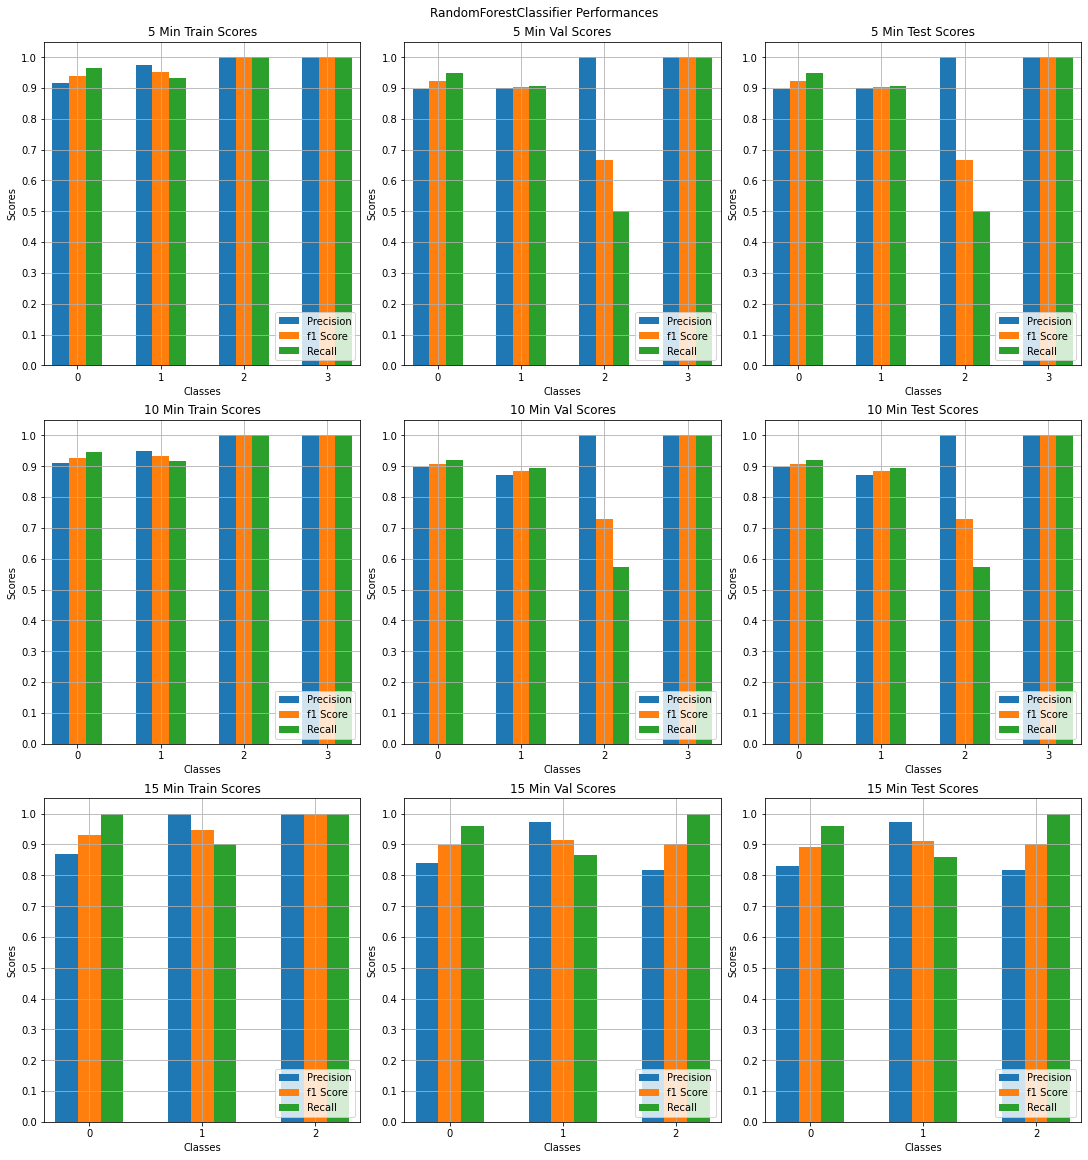

In [34]:
fig, ax = plt.subplots(3,3,figsize=(15,16), constrained_layout=True)
fig.suptitle("RandomForestClassifier Performances")
for i, time_offset in enumerate(df_timed_dct):
    if i>=3:
        break
    model = RandomForestClassifier(max_depth=10, random_state=0)
    accuracies, precisions, recalls, f1_scores, supports, classes = get_predict(df_timed_dct[time_offset],
                                                                        model, 
                                                                        f"Weather {time_offset} Min",
                                                                        ["TARGET_WEATHER"],
                                                                        ["TARGET_WEATHER", "TARGET_RAIN_PERCENTAGE"],
                                                                        get_classification_metrics)
    plot_scores_to_ax(ax[i], precisions, recalls, f1_scores, classes, time_offset)
#fig.savefig('RandomForestClassifier.jpeg')    
plt.show()    

## RAIN_PERCENTAGE

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=10, random_state=0)
for time_offset in df_timed_dct:
    get_predict(df_timed_dct[time_offset], model, f"Weather {time_offset} Min", ["TARGET_RAIN_PERCENTAGE"], 
                ["TARGET_WEATHER","TARGET_RAIN_PERCENTAGE"], get_regression_metrics)

## Class Distribution

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train)
plt.show()

In [ ]:
plt.hist(y_test)
plt.show()

In [ ]:
set(y_test)